In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from IPython.display import display


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load the dataset
UTKFace

In [3]:
images = []
ages = []
races = []
genders = []

for i in os.listdir('./UTKFace/crop_part1'):
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    races.append(int(split[2]))
    with Image.open('./UTKFace/crop_part1/' + i) as img:
        images.append(img.copy())

In [4]:
images = pd.Series(list(images), name = 'Image')
ages = pd.Series(list(ages), name = 'Age')
genders = pd.Series(list(genders), name = 'Gender')
races = pd.Series(list(races), name = 'Race')

df = pd.concat([images, ages, genders, races], axis=1)
df

,Image,Age,Gender,Race
0,<PIL.Image.Image image mode=RGB size=200x200 a...,100,1,0
1,<PIL.Image.Image image mode=RGB size=200x200 a...,100,1,2
2,<PIL.Image.Image image mode=RGB size=200x200 a...,101,1,2
3,<PIL.Image.Image image mode=RGB size=200x200 a...,10,0,0
4,<PIL.Image.Image image mode=RGB size=200x200 a...,10,0,0
...,...,...,...,...
9773,<PIL.Image.Image image mode=RGB size=200x200 a...,9,1,3
9774,<PIL.Image.Image image mode=RGB size=200x200 a...,9,1,3
9775,<PIL.Image.Image image mode=RGB size=200x200 a...,9,1,4
9776,<PIL.Image.Image image mode=RGB size=200x200 a...,9,1,4


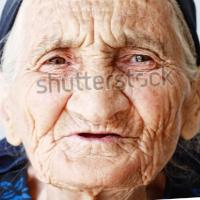

100 1 0


In [5]:
i=0
display(df['Image'][i])
print(df['Age'][i], df['Gender'][i], df['Race'][i])

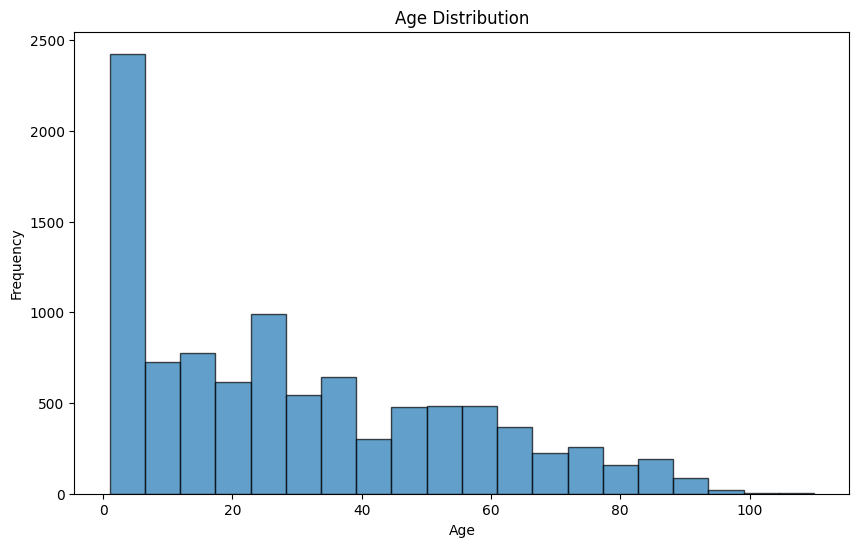

In [6]:
# Lets plot a histogram of the ages
ages = df['Age']  # Get the last age

# Plot the histogram to visualize the age distribution
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [7]:
under4s = []

for i in range(len(df)):
    if df['Age'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Age'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

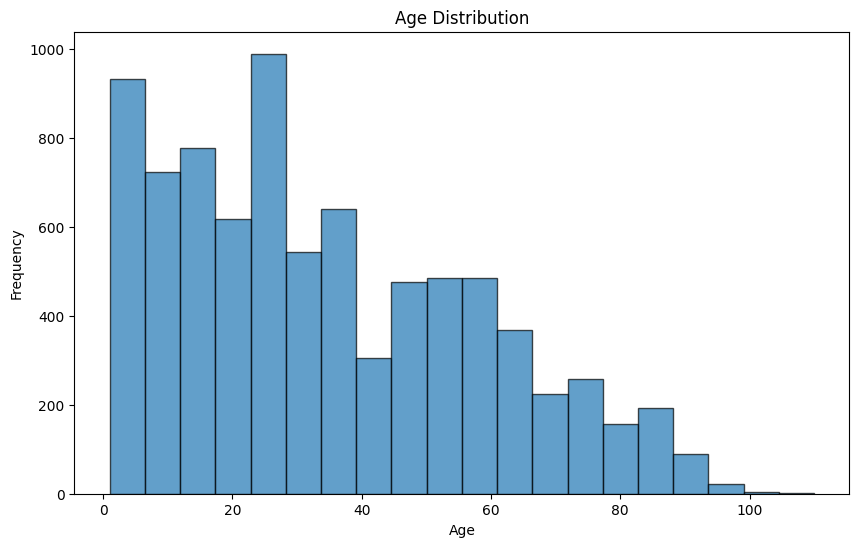

In [8]:
# Lets plot a histogram of the ages
ages = df['Age']  # Get the last age

# Plot the histogram to visualize the age distribution
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Collecting filenames and metadata
        self.data = []
        for i in os.listdir(image_dir):
            if i.endswith('.jpg'):
                split = i.split('_')
                if len(split) >= 3:
                    age = int(split[0])
                    gender = int(split[1])
                    race = int(split[2])
                    self.data.append((i, age, gender, race))  # Storing filename and labels
                else:
                    print(f"Skipping file with unexpected format: {i}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name, age, gender, race = self.data[idx]
        img_path = os.path.join(self.image_dir, file_name)

        # Load image
        image = decode_jpeg(read_file(img_path), device="cpu").to('cuda')
        image = image.float() / 255.0  # Normalize to [0, 1]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Return image and label (you can modify to return age, gender, or race)
        return image, age, gender, race  # Returning age as label


        
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = './UTKFace/crop_part1'
test_dataset = CustomDataset(image_dir=test_dir, transform=test_transforms)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=True
)

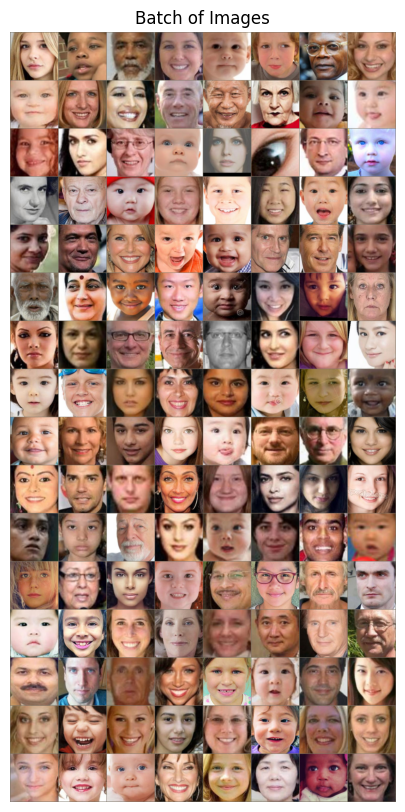

Labels for the batch: tensor([17,  7, 53, 23,  2,  5, 66, 24,  3, 38, 34, 67, 65, 85,  1,  1,  7, 25,
        53,  1, 22,  1, 40,  3, 55, 75,  1, 17,  7, 18,  5, 26, 26, 43, 39,  3,
         1, 65, 61, 12, 75, 56,  5, 19,  1, 21,  5, 69, 27, 38, 54, 57, 35, 25,
        10, 28,  5, 15, 22, 53, 28,  2, 16,  1,  1, 41, 18, 10,  2, 39, 64, 15,
        25, 29, 29, 55, 22, 20, 21, 14, 28, 10, 75, 24,  1, 29, 25,  1, 11, 70,
        22,  4, 47, 14, 75, 25,  1, 12, 27, 60, 44, 50, 62, 60, 46, 39, 63, 46,
         8,  2, 36, 24, 27,  5, 20, 18, 42,  2, 35, 24, 13,  6,  1, 60,  8, 56,
         1, 43])


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as T

# Get a single batch from the DataLoader
data_iter = iter(test_loader)
images, labels, _, _ = next(data_iter)

# Convert the batch of images to a grid for easier visualization
grid = torchvision.utils.make_grid(images.cpu(), nrow=8, padding=2)

# Convert tensor to NumPy array for display
grid = grid.permute(1, 2, 0).numpy()

# Normalize the image back to [0, 1] for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
grid = std * grid + mean  # Reversing normalization

# Clip values to [0, 1]
grid = np.clip(grid, 0, 1)

# Plot the image grid
plt.figure(figsize=(10, 10))
plt.imshow(grid)
plt.title('Batch of Images')
plt.axis('off')
plt.show()

# Print labels for the batch
print("Labels for the batch:", labels)


# Bias investigation

## Binary Classification Model

In [11]:
# Change to apropriate model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

model.fc = nn.Linear(num_features, 1)

saved_model_path = './models/ResNet50_fc+layer4_2025-01-22_v1.pth'
model.load_state_dict(torch.load(saved_model_path, weights_only=True))
model.to(device)
model.eval()

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Number of features from pre-trained model 2048


In [12]:
from collections import defaultdict

def test_binary(model, device, test_loader, criterion, decision_boundary=0.7):
    model.eval()  # Set model to evaluation mode

    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []
    all_probs = []

    # Track results for each gender and race
    gender_stats = defaultdict(lambda: {"targets": [], "preds": [], "probs": []})
    race_stats = defaultdict(lambda: {"targets": [], "preds": [], "probs": []})

    with torch.no_grad():
        for data, target, gender, race in test_loader:
            data, target, gender, race = data.to(device), target.to(device), gender.cpu().numpy(), race.cpu().numpy()
            target = (target > 25).float()

            # Compute loss
            output = model(data)  # Output is logits       
            test_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)

            # Get predictions by thresholding at 0.5
            pred = (output > decision_boundary).float()

            # Store overall stats
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(output.cpu().numpy())

            # Store stats for gender and race
            for i in range(len(target)):
                gender_stats[gender[i]]["targets"].append(target[i].item())
                gender_stats[gender[i]]["preds"].append(pred[i].item())
                gender_stats[gender[i]]["probs"].append(output[i].item())

                race_stats[race[i]]["targets"].append(target[i].item())
                race_stats[race[i]]["preds"].append(pred[i].item())
                race_stats[race[i]]["probs"].append(output[i].item())

            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute overall metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    auc_roc = auc(fpr, tpr)

    # Compute metrics for each gender
    gender_results = {}
    for gender, data in gender_stats.items():
        gender_results[gender] = compute_metrics(data["targets"], data["preds"], data["probs"])

    # Compute metrics for each race
    race_results = {}
    for race, data in race_stats.items():
        race_results[race] = compute_metrics(data["targets"], data["preds"], data["probs"])

    return {
        "overall": {
            "loss": round(test_loss,3),
            "accuracy": round(test_accuracy,3),
            "precision": round(precision,3),
            "recall": round(recall,3),
            "f1_score": round(f1,3),
            "confusion_matrix": (tn, fp, fn, tp),
            "auc_roc": round(auc_roc,3),
        },
        "gender_results": gender_results,
        "race_results": race_results,
    }

def compute_metrics(targets, preds, probs):
    """Helper function to compute metrics for subgroups (gender/race)."""
    if len(targets) == 0:  # Avoid division by zero
        return {"accuracy": None, "precision": None, "recall": None, "f1_score": None, "auc_roc": None}

    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, zero_division=0)
    recall = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
    fpr, tpr, _ = roc_curve(targets, probs)
    auc_roc = auc(fpr, tpr)

    return {
        "accuracy": round(accuracy,3),
        "precision": round(precision,3),
        "recall": round(recall,3),
        "f1_score": round(f1,3),
        "confusion_matrix": (tn, fp, fn, tp),
        "auc_roc": round(auc_roc,3),
    }
criterion = nn.BCEWithLogitsLoss()
test_results = test_binary(model, device, test_loader, criterion)

In [13]:
overall_metrics = {key: value for key, value in test_results["overall"].items() if key != "confusion_matrix"}
overall_df = pd.DataFrame(overall_metrics, index=[0])
print("Overall Performance:")
display(overall_df)

# Gender-specific results
gender_data = []
for gender, metrics in test_results["gender_results"].items():
    gender_label = "Female" if gender else "Male"
    gender_data.append({"Gender": gender_label, **metrics})
gender_df = pd.DataFrame(gender_data)
print("\nPerformance by Gender:")
display(gender_df.drop(columns=['confusion_matrix']))

# Race-specific results
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_data = []
for race, metrics in test_results["race_results"].items():
    race_label = race_labels.get(race, "Unknown")
    race_data.append({"Race": race_label, **metrics})
race_df = pd.DataFrame(race_data)
print("\nPerformance by Race:")
display(race_df.drop(columns=['confusion_matrix']))

Overall Performance:


,loss,accuracy,precision,recall,f1_score,auc_roc
0,0.466,86.02,0.873,0.837,0.855,0.939



Performance by Gender:


,Gender,accuracy,precision,recall,f1_score,auc_roc
0,Male,0.918,0.917,0.926,0.921,0.975
1,Female,0.813,0.829,0.758,0.792,0.900



Performance by Race:


,Race,accuracy,precision,recall,f1_score,auc_roc
0,Asian,0.869,0.820,0.660,0.731,0.924
1,Indian,0.777,0.767,0.707,0.736,0.863
2,White,0.891,0.926,0.890,0.908,0.958
3,Other,0.816,0.684,0.801,0.738,0.905
4,Black,0.842,0.866,0.843,0.855,0.931


In [14]:
overall_df = pd.DataFrame.from_dict(test_results["overall"])
tn, fp, fn, tp = overall_df['confusion_matrix']
conf_matrix_df = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    columns=["Pred 0", "Pred 1"],
    index=["Act 0", "Act 1"]
)

# Normalize by total sum
conf_matrix_total = round(conf_matrix_df / conf_matrix_df.values.sum(),2)

print('Combined Confusion Matrix:')
display(conf_matrix_total)

Combined Confusion Matrix:


,Pred 0,Pred 1
Act 0,0.45,0.06
Act 1,0.08,0.41


## Multiclass Model

In [15]:
# Change to apropriate model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 4)

saved_model_path = './models/multiclass/ResNet18_GradualUnfreeze_2025-02-06_v1.pth'
model.load_state_dict(torch.load(saved_model_path, weights_only=True))
model.to(device)
model.eval()

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Number of features from pre-trained model 512


In [16]:
def test_multiclass(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode

    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []

    # Track results for each gender and race
    gender_stats = defaultdict(lambda: {"targets": [], "preds": []})
    race_stats = defaultdict(lambda: {"targets": [], "preds": []})
    bins = torch.tensor([18, 28, 40], device=device)  # Define bin edges

    with torch.no_grad():
        for data, target, gender, race in test_loader:
            data, target = data.to(device), target.to(device)
            gender, race = gender.cpu().numpy(), race.cpu().numpy()
            
            # Convert continuous ages into bins (0,1,2,3)
            target = torch.bucketize(target, bins, right=True)

            # Forward pass
            output = model(data)  # Logits (raw scores)
            
            # Compute loss
            test_loss += criterion(output, target).item()  # Sum up batch loss

            # Get predictions
            pred = torch.argmax(output, dim=1)

            # Store overall stats
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # Store stats for gender and race
            for i in range(len(target)):
                gender_stats[gender[i]]["targets"].append(target[i].item())
                gender_stats[gender[i]]["preds"].append(pred[i].item())

                race_stats[race[i]]["targets"].append(target[i].item())
                race_stats[race[i]]["preds"].append(pred[i].item())

            # Update correct count (compare predictions to target)
            correct += pred.eq(target).sum().item()

    # Compute overall metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Multi-class metrics
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    cm = confusion_matrix(all_targets, all_preds)  # Multi-class confusion matrix

    # Compute metrics for each gender
    gender_results = {}
    for gender, data in gender_stats.items():
        gender_results[gender] = compute_multiclass_metrics(data["targets"], data["preds"])

    # Compute metrics for each race
    race_results = {}
    for race, data in race_stats.items():
        race_results[race] = compute_multiclass_metrics(data["targets"], data["preds"])

    return {
        "overall": {
            "loss": round(test_loss, 3),
            "accuracy": round(test_accuracy, 3),
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1_score": round(f1, 3),
            "confusion_matrix": cm.tolist(),  # Return as list for easier logging
        },
        "gender_results": gender_results,
        "race_results": race_results,
    }

def compute_multiclass_metrics(targets, preds):
    """Helper function to compute multi-class metrics for subgroups (gender/race)."""
    if len(targets) == 0:  # Avoid division by zero
        return {"accuracy": None, "precision": None, "recall": None, "f1_score": None}

    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average="macro", zero_division=0)
    recall = recall_score(targets, preds, average="macro", zero_division=0)
    f1 = f1_score(targets, preds, average="macro", zero_division=0)
    cm = confusion_matrix(targets, preds)  # Multi-class confusion matrix

    return {
        "accuracy": round(accuracy, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1_score": round(f1, 3),
        "confusion_matrix": cm.tolist(),
    }

# Example usage:
criterion = nn.CrossEntropyLoss()
test_results = test_multiclass(model, device, test_loader, criterion)

In [17]:
overall_metrics = {key: value for key, value in test_results["overall"].items() if key != "confusion_matrix"}
overall_df = pd.DataFrame(overall_metrics, index=[0])
print("Overall Performance:")
display(overall_df)


# Gender-specific results
gender_data = []
for gender, metrics in test_results["gender_results"].items():
    gender_label = "Female" if gender else "Male"
    gender_data.append({"Gender": gender_label, **metrics})
gender_df = pd.DataFrame(gender_data)
print("\nPerformance by Gender:")
display(gender_df.drop(columns=['confusion_matrix']))

# Race-specific results
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_data = []
for race, metrics in test_results["race_results"].items():
    race_label = race_labels.get(race, "Unknown")
    race_data.append({"Race": race_label, **metrics})
race_df = pd.DataFrame(race_data)
print("\nPerformance by Race:")
display(race_df.drop(columns=['confusion_matrix']))

Overall Performance:


,loss,accuracy,precision,recall,f1_score
0,0.967,72.346,0.625,0.613,0.602



Performance by Gender:


,Gender,accuracy,precision,recall,f1_score
0,Male,0.772,0.649,0.660,0.633
1,Female,0.684,0.598,0.587,0.573



Performance by Race:


,Race,accuracy,precision,recall,f1_score
0,White,0.742,0.617,0.611,0.590
1,Indian,0.650,0.596,0.582,0.578
2,Asian,0.782,0.646,0.571,0.581
3,Other,0.665,0.599,0.589,0.577
4,Black,0.679,0.553,0.556,0.550


In [18]:
import numpy as np
import pandas as pd

# Overall confusion matrix
overall_df = pd.DataFrame.from_dict(test_results["overall"])
conf_matrix_overall = overall_df['confusion_matrix']

# Ensure the confusion matrix is a numpy array
conf_matrix_overall = np.array(conf_matrix_overall.tolist()) 

# Normalize the overall confusion matrix
conf_matrix_normalized_overall = conf_matrix_overall.astype('float') / conf_matrix_overall.sum(axis=1)[:, np.newaxis]
conf_matrix_df_overall = pd.DataFrame(
    conf_matrix_normalized_overall,
    columns=[f'Pred {i}' for i in range(4)],
    index=[f'Act {i}' for i in range(4)]
)

print('Overall Confusion Matrix:')
display(conf_matrix_df_overall.round(2))

# Gender-specific confusion matrices
for gender, metrics in test_results["gender_results"].items():
    conf_matrix_gender = metrics['confusion_matrix']
    conf_matrix_gender = np.array(conf_matrix_gender)

    # Normalize the gender confusion matrix
    conf_matrix_normalized_gender = conf_matrix_gender.astype('float') / conf_matrix_gender.sum(axis=1)[:, np.newaxis]
    conf_matrix_df_gender = pd.DataFrame(
        conf_matrix_normalized_gender,
        columns=[f'Pred {i}' for i in range(4)],
        index=[f'Act {i}' for i in range(4)]
    )

    gender_label = "Female" if gender else "Male"
    print(f'\nConfusion Matrix for {gender_label}:')
    display(conf_matrix_df_gender.round(2))

# Race-specific confusion matrices
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
for race, metrics in test_results["race_results"].items():
    conf_matrix_race = metrics['confusion_matrix']
    conf_matrix_race = np.array(conf_matrix_race) 

    # Normalize the race confusion matrix
    conf_matrix_normalized_race = conf_matrix_race.astype('float') / conf_matrix_race.sum(axis=1)[:, np.newaxis]
    conf_matrix_df_race = pd.DataFrame(
        conf_matrix_normalized_race,
        columns=[f'Pred {i}' for i in range(4)],
        index=[f'Act {i}' for i in range(4)]
    )

    race_label = race_labels.get(race, "Unknown")
    print(f'\nConfusion Matrix for {race_label}:')
    display(conf_matrix_df_race.round(2))


Overall Confusion Matrix:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.88,0.09,0.02,0.01
Act 1,0.31,0.57,0.07,0.06
Act 2,0.11,0.40,0.17,0.32
Act 3,0.03,0.09,0.04,0.84



Confusion Matrix for Male:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.87,0.10,0.02,0.01
Act 1,0.17,0.66,0.11,0.06
Act 2,0.06,0.38,0.24,0.31
Act 3,0.02,0.07,0.05,0.86



Confusion Matrix for Female:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.89,0.09,0.02,0.00
Act 1,0.36,0.53,0.05,0.06
Act 2,0.15,0.41,0.12,0.32
Act 3,0.05,0.10,0.04,0.81



Confusion Matrix for White:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.84,0.13,0.02,0.01
Act 1,0.29,0.55,0.06,0.09
Act 2,0.08,0.31,0.18,0.44
Act 3,0.02,0.07,0.04,0.87



Confusion Matrix for Indian:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.86,0.11,0.03,0.01
Act 1,0.22,0.65,0.09,0.04
Act 2,0.12,0.59,0.15,0.14
Act 3,0.05,0.18,0.09,0.67



Confusion Matrix for Asian:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.98,0.02,0.01,0.00
Act 1,0.50,0.46,0.02,0.01
Act 2,0.25,0.44,0.12,0.19
Act 3,0.10,0.11,0.06,0.73



Confusion Matrix for Other:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.87,0.10,0.01,0.01
Act 1,0.31,0.58,0.06,0.05
Act 2,0.09,0.49,0.21,0.21
Act 3,0.04,0.18,0.09,0.69



Confusion Matrix for Black:


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.83,0.11,0.05,0.01
Act 1,0.31,0.41,0.18,0.10
Act 2,0.20,0.31,0.19,0.30
Act 3,0.05,0.09,0.06,0.80


## Regression Model